<a href="https://colab.research.google.com/github/hashmatr/Deep_Learning_Labs_Nust/blob/main/Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Lab 4: Hyperparameter Tuning in Neural Network**

Most machine learning workflows involve working with data, creating models, optimizing model parameters, and saving the trained models. This lab introduces you to a complete ML workflow implemented in PyTorch covering all these steps.

### **Task 1**

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
import numpy as np

Check if GPU is available.

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print ('<== CUDA availability : ==>', use_cuda)

<== CUDA availability : ==> True


Set seed for reproducability.

In [3]:
def set_seeds(seed):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.determinictic = True
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
set_seeds(42)

PyTorch offers domain-specific libraries such as <b>TorchText, TorchVision, and TorchAudio,</b> all of which include datasets. For this lab, we will be using a TorchVision dataset. Load one of the prebuilt datasets from pytorch repository. Currently, we are not using any transform (manipulation) on input data. We are just converting each image to tensor.


In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


Visualise some of the input images.

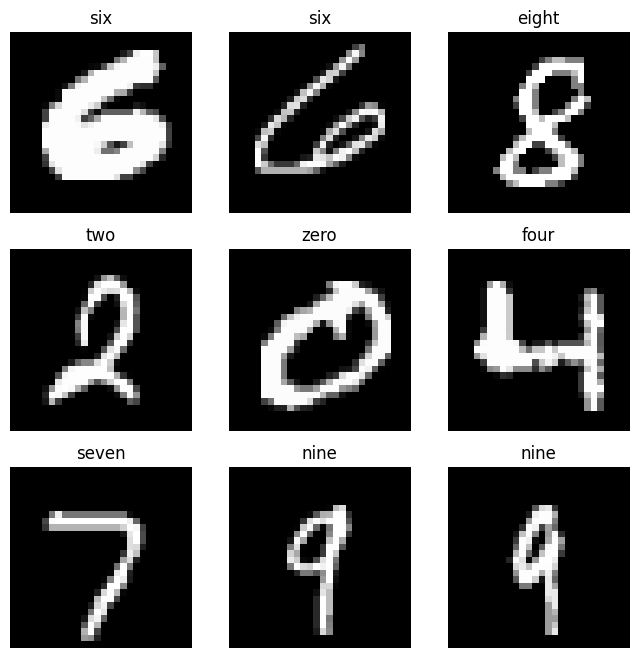

In [5]:
labels_map = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()  # randomly pick indices from the training data
    img, label = training_data[sample_idx]                            # Read the images using their indices.
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Check the size and shape of training and validation data.

In [6]:
# Visualize the size of the datasets

print(f"Training data size: {len(training_data)} samples")
print(f"Test data size: {len(test_data)} samples")

Training data size: 60000 samples
Test data size: 10000 samples


In [7]:
# Visualize the shape of a single image and its label

train_image, train_label = training_data[0]  # Get the first training sample
test_image, test_label = test_data[0]        # Get the first test sample

print(f"Shape of a training image: {train_image.shape}")  # (1, 28, 28) - 1 channel, 28x28 pixels
print(f"Shape of a test image: {test_image.shape}")
print(f"Training label: {train_label}")
print(f"Test label: {test_label}")

Shape of a training image: torch.Size([1, 28, 28])
Shape of a test image: torch.Size([1, 28, 28])
Training label: 5
Test label: 7


The shape of the training set is (6000,2). This means that we have 6000 thousand samples with 2 entities. The first entity is the image and the second entity is its label. Forexample:

**training_data[0][0]** is the first image of training set

**training_data[0][1]** is the label of the first image in the training set

Now pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [9]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}") #[batch_size, channels, height, width]
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the __init__ function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [12]:
import torch
import torch.nn as nn

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),   # Changed 128 → 512
            nn.ReLU(),
            nn.Linear(512, 512),    # Changed 128 → 512
            nn.ReLU(),
            nn.Linear(512, 10)      # Output layer remains 10
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


# Move model to device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = NeuralNetwork().to(device)

print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


**Q1: You may change the width of each layer from 128 to 256 and 512 and observe the difference in network performance.**

**Try adding and removing layers. Keeping all other setup the same, how does the network behave with the change in depth (number of layers) and width (size of each layer)?**

Ans) When we increase or decrease the width (number of neurons per layer) and depth (number of layers) of a neural network, we change the model capacity, which directly affects performance.

Now define the loss function and set up optimiser.

In [13]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-4 )

**Q2: Try changing the learning rate from 1e-3 to 1e-4. What do you observe?**

**Try the Adam optimizer instead of SGD. How the learning process changes?**   
Ans) When changing from 1e-3 to 1e-4:

Training loss decreases more slowly

Model converges more smoothly

Final accuracy may be similar, but training time increases


Define train function.

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    running_loss = 0                            # accumuate loss of each input sample
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)       # assign input samples to the available device (CPU or GPU) for computation.

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()  # set the gradients to zero to avoid gradient accumuation. Gradient Accumulation is useful in some cases, like in training RNN.
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"training loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/len(dataloader)

Define evaluation function.

In [15]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():         # No gradients need to be calculated for evaluation. Just the forward pass.
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size               # Normalise correctly classified count.
    print(f"test loss: \nAccuracy: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f} \n")

    return test_loss

Initiate Training Process

Epoch 1
-------------------------------
test loss: 
Accuracy: 14.9%, avg loss: 2.300044 

Epoch 2
-------------------------------
test loss: 
Accuracy: 16.7%, avg loss: 2.295979 

Epoch 3
-------------------------------
test loss: 
Accuracy: 19.2%, avg loss: 2.291888 

Epoch 4
-------------------------------
test loss: 
Accuracy: 23.0%, avg loss: 2.287752 

Epoch 5
-------------------------------
test loss: 
Accuracy: 26.7%, avg loss: 2.283551 

Done!


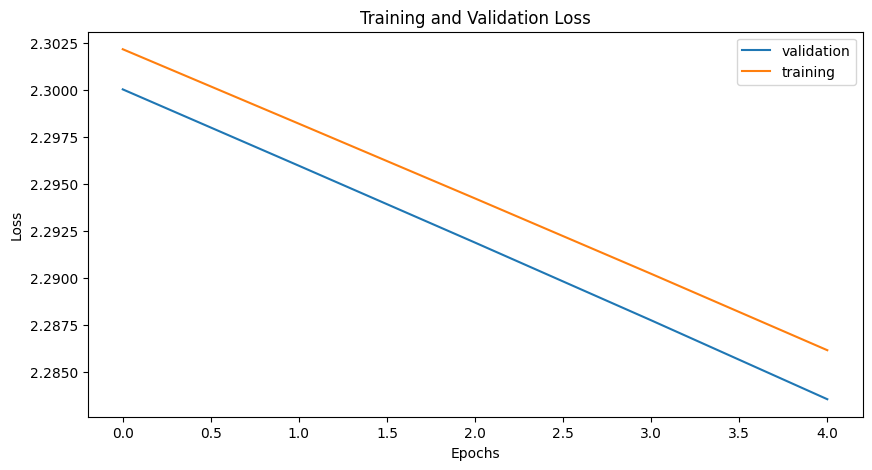

In [16]:
epochs = 5
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Q3: Try 5, 10 and 50 epoch and record values for average validation loss and accuracy**

Epoch 1
-------------------------------
test loss: 
Accuracy: 30.4%, avg loss: 2.279267 

Epoch 2
-------------------------------
test loss: 
Accuracy: 34.2%, avg loss: 2.274880 

Epoch 3
-------------------------------
test loss: 
Accuracy: 37.5%, avg loss: 2.270372 

Epoch 4
-------------------------------
test loss: 
Accuracy: 41.0%, avg loss: 2.265724 

Epoch 5
-------------------------------
test loss: 
Accuracy: 44.4%, avg loss: 2.260914 

Epoch 6
-------------------------------
test loss: 
Accuracy: 47.3%, avg loss: 2.255924 

Epoch 7
-------------------------------
test loss: 
Accuracy: 49.9%, avg loss: 2.250733 

Epoch 8
-------------------------------
test loss: 
Accuracy: 52.1%, avg loss: 2.245317 

Epoch 9
-------------------------------
test loss: 
Accuracy: 53.7%, avg loss: 2.239658 

Epoch 10
-------------------------------
test loss: 
Accuracy: 55.3%, avg loss: 2.233734 

Done!


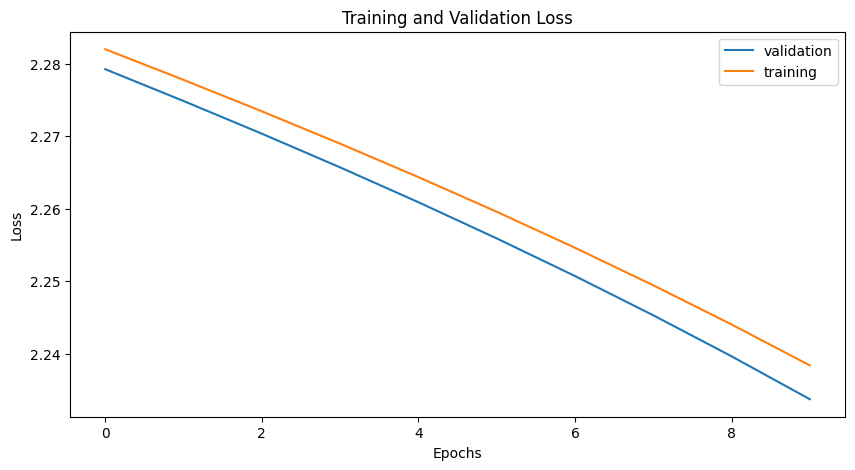

In [17]:
epochs = 10
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch 1
-------------------------------
test loss: 
Accuracy: 56.6%, avg loss: 2.227522 

Epoch 2
-------------------------------
test loss: 
Accuracy: 57.6%, avg loss: 2.220998 

Epoch 3
-------------------------------
test loss: 
Accuracy: 58.6%, avg loss: 2.214141 

Epoch 4
-------------------------------
test loss: 
Accuracy: 59.3%, avg loss: 2.206924 

Epoch 5
-------------------------------
test loss: 
Accuracy: 60.0%, avg loss: 2.199320 

Epoch 6
-------------------------------
test loss: 
Accuracy: 60.5%, avg loss: 2.191298 

Epoch 7
-------------------------------
test loss: 
Accuracy: 60.9%, avg loss: 2.182832 

Epoch 8
-------------------------------
test loss: 
Accuracy: 61.3%, avg loss: 2.173885 

Epoch 9
-------------------------------
test loss: 
Accuracy: 61.7%, avg loss: 2.164423 

Epoch 10
-------------------------------
test loss: 
Accuracy: 62.0%, avg loss: 2.154414 

Epoch 11
-------------------------------
test loss: 
Accuracy: 62.1%, avg loss: 2.143822 

Epoch 12

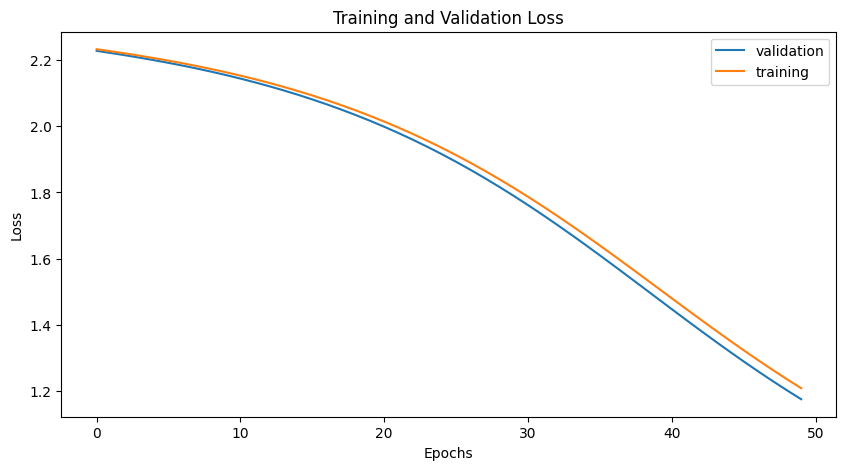

In [18]:
epochs = 50
train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)

print("Done!")

# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(test_losses,label="validation")
plt.plot(train_losses,label="training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Q4: What activation function is generally used for multiclass classification? Why didn't we use an activation function at the end of our neural network that we have defined?**    
Ans) Softmax is generally used for multiclass classification to convert logits into probabilities. We didn’t add it in our model because CrossEntropyLoss in PyTorch automatically applies it internally, so manual Softmax is unnecessary during training.

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Perform Inferrence

Predicted: "six", Actual: "four"


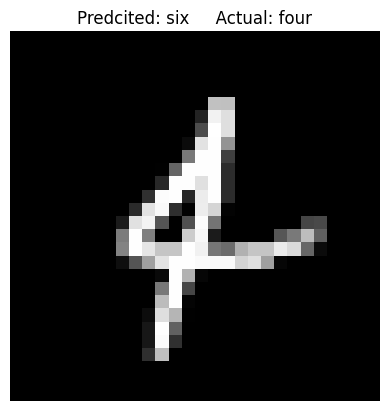

In [ ]:
classes = [
    "zero",
    "one",
    "two",
    "three",
    "four",
    "five",
    "six",
    "seven",
    "eight",
    "nine",
]
#classes = np.array(test_data.class_to_idx.values())
#testimg = random.
model.eval()
sample_number = 300 # Keep 0 <= sample_number < 10,000
x, y = test_data[sample_number][0], test_data[sample_number][1]
model.to("cpu")
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

img, label = test_data[sample_number]                            # Read the images using their indices.
    #figure.add_subplot(rows, cols, i)
plt.figure()
plt.title("Predcited: "+ predicted + "     Actual: " + labels_map[label])
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")

### **Task 2**

*Repeat all of above steps for Fashion MNIST dataset, apply question 1, 2 and 3 and report the accuracies.**

### **Submission Guidelines**

> Along with jupyter file submit a lab report containing screenshots of codes & output and tables for comparision of accuracies for both task 1 and task2 (for both MNIST and Fashion MNIST datasets).

> Try to achieve the best accuracies you can in classifying the images.

> Remember, the more you elaborate your report, the higher the marks you will get.

> This is a group lab. You are advised to make a group of 2. PS: clearly mention the name, registration number and contribution of each group member at the top.

# Task
Repeat the machine learning workflow for the Fashion MNIST dataset, including loading the data, visualizing samples, inspecting data dimensions, creating `DataLoader` instances, defining a neural network, and then conducting three experiments:
1. Train a baseline neural network (width 512, SGD optimizer with 1e-4 learning rate) for 5, 10, and 50 epochs, recording validation loss and accuracy.
2. Train a neural network with reduced width (256, SGD optimizer with 1e-4 learning rate) for 5, 10, and 50 epochs, recording validation loss and accuracy.
3. Train a neural network with the Adam optimizer (width 512, 1e-3 learning rate) for 5, 10, and 50 epochs, recording validation loss and accuracy.
Finally, summarize and compare the results from all experiments, and perform inference on a sample from the Fashion MNIST test set.

## Load Fashion MNIST Dataset

### Subtask:
Load the Fashion MNIST training and test datasets using `torchvision.datasets.FashionMNIST`. Apply `ToTensor()` transform.


**Reasoning**:
Load the Fashion MNIST training and test datasets using `torchvision.datasets.FashionMNIST` with the specified parameters.



In [19]:
fashion_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

fashion_test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

print("Fashion MNIST training data loaded successfully.")
print("Fashion MNIST test data loaded successfully.")

100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 4.04MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 60.4MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.6MB/s]


Fashion MNIST training data loaded successfully.
Fashion MNIST test data loaded successfully.


**Reasoning**:
The previous step successfully loaded the Fashion MNIST dataset. The next logical step, following the structure of Task 1, is to visualize some of the input images from the newly loaded Fashion MNIST dataset. This requires defining a new `labels_map` for Fashion MNIST classes and adapting the visualization code.



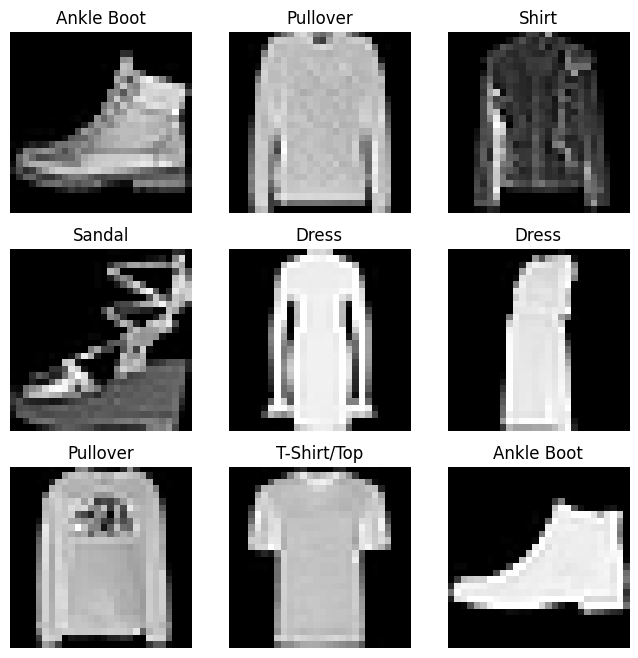

In [21]:
fashion_labels_map = {
    0: "T-Shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fashion_training_data), size=(1,)).item()
    img, label = fashion_training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(fashion_labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


**Reasoning**:
Following the previous data loading and visualization steps, it's important to inspect the size and shape of the Fashion MNIST training and test datasets to ensure they are loaded correctly and understand their dimensions, similar to what was done for the MNIST dataset.



In [23]:
print(f"Fashion MNIST Training data size: {len(fashion_training_data)} samples")
print(f"Fashion MNIST Test data size: {len(fashion_test_data)} samples")

fashion_train_image, fashion_train_label = fashion_training_data[0]
fashion_test_image, fashion_test_label = fashion_test_data[0]

print(f"Shape of a Fashion MNIST training image: {fashion_train_image.shape}")
print(f"Shape of a Fashion MNIST test image: {fashion_test_image.shape}")
print(f"Fashion MNIST training label: {fashion_train_label}")
print(f"Fashion MNIST test label: {fashion_test_label}")

Fashion MNIST Training data size: 60000 samples
Fashion MNIST Test data size: 10000 samples
Shape of a Fashion MNIST training image: torch.Size([1, 28, 28])
Shape of a Fashion MNIST test image: torch.Size([1, 28, 28])
Fashion MNIST training label: 9
Fashion MNIST test label: 9


**Reasoning**:
Now that the Fashion MNIST dataset is loaded and its dimensions are inspected, the next step is to create `DataLoader` instances for both the training and test datasets. This will enable efficient batching and iteration over the data during the model training and evaluation phases, consistent with the previous task's methodology.



In [24]:
batch_size = 64

# Create data loaders for Fashion MNIST.
fashion_train_dataloader = DataLoader(fashion_training_data, batch_size=batch_size)
fashion_test_dataloader = DataLoader(fashion_test_data, batch_size=batch_size)

print("Fashion MNIST DataLoaders created successfully.")

for X, y in fashion_test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}") # [batch_size, channels, height, width]
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Fashion MNIST DataLoaders created successfully.
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


**Reasoning**:
With the Fashion MNIST data loaders prepared, the next step is to define the neural network model. This involves creating a class that inherits from `nn.Module`, defining the network layers, and moving the model to the available device (CPU or GPU) to prepare for training, mirroring the approach used for the MNIST dataset.



In [25]:
class FashionNeuralNetwork(nn.Module):
    def __init__(self, layer_width=512):
        super(FashionNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, layer_width),
            nn.ReLU(),
            nn.Linear(layer_width, layer_width),
            nn.ReLU(),
            nn.Linear(layer_width, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Move model to device (CPU or GPU)
fashion_model_512 = FashionNeuralNetwork(layer_width=512).to(device)
print("Baseline Fashion Neural Network (width 512) defined and moved to device.")
print(fashion_model_512)


Baseline Fashion Neural Network (width 512) defined and moved to device.
FashionNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


**Reasoning**:
Now that the baseline Fashion Neural Network is defined, the next step is to define the loss function and the optimizer (SGD with learning rate 1e-4) to prepare for training, following the pattern of Task 1.



In [26]:
fashion_loss_fn = nn.CrossEntropyLoss()
fashion_optimizer_sgd_1e4 = torch.optim.SGD(fashion_model_512.parameters(), lr=1e-4)

print("Loss function (CrossEntropyLoss) and SGD optimizer (lr=1e-4) defined for the baseline Fashion MNIST model.")

Loss function (CrossEntropyLoss) and SGD optimizer (lr=1e-4) defined for the baseline Fashion MNIST model.


**Reasoning**:
The next step is to execute the first experiment, which involves training the baseline Fashion MNIST neural network (width 512) using the SGD optimizer (lr=1e-4) for 5, 10, and 50 epochs. This requires calling the previously defined `train` and `test` functions for each epoch count and recording the validation loss and accuracy.




--- Starting Experiment: Baseline_512_SGD_1e4_5E for 5 epochs ---
Epoch 1
-------------------------------
test loss: 
Accuracy: 15.3%, avg loss: 2.288090 

Epoch 2
-------------------------------
test loss: 
Accuracy: 19.9%, avg loss: 2.273546 

Epoch 3
-------------------------------
test loss: 
Accuracy: 24.0%, avg loss: 2.259016 

Epoch 4
-------------------------------
test loss: 
Accuracy: 26.8%, avg loss: 2.244327 

Epoch 5
-------------------------------
test loss: 
Accuracy: 28.8%, avg loss: 2.229306 

--- Experiment Baseline_512_SGD_1e4_5E Done! ---

--- Starting Experiment: Baseline_512_SGD_1e4_10E for 10 epochs ---
Epoch 1
-------------------------------
test loss: 
Accuracy: 12.2%, avg loss: 2.290878 

Epoch 2
-------------------------------
test loss: 
Accuracy: 20.0%, avg loss: 2.279036 

Epoch 3
-------------------------------
test loss: 
Accuracy: 24.8%, avg loss: 2.267255 

Epoch 4
-------------------------------
test loss: 
Accuracy: 27.2%, avg loss: 2.255353 

Epoch

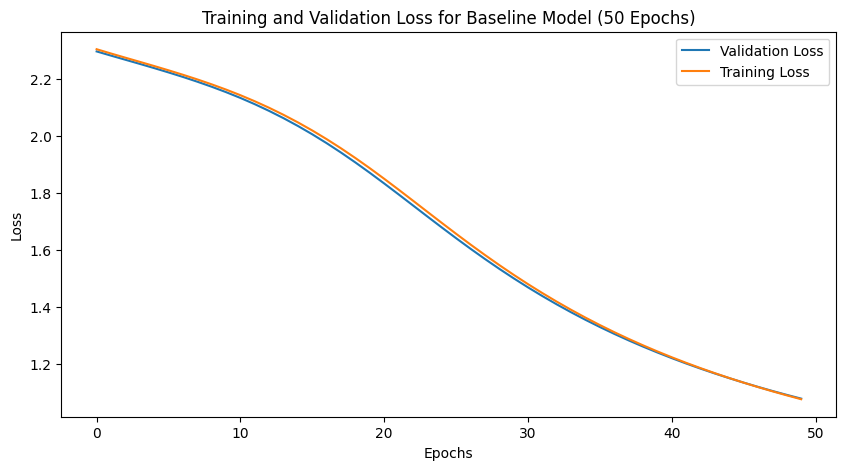

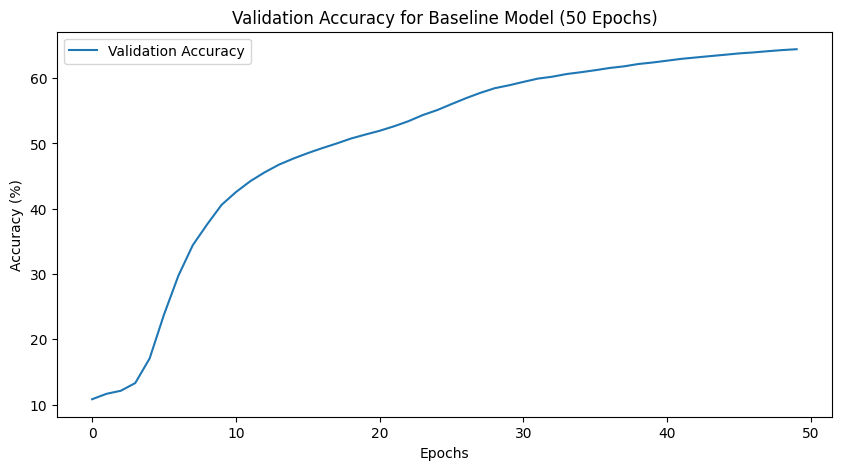

In [27]:
results_baseline_512_sgd_1e4 = {}

# Helper function to run training for a given number of epochs
def run_experiment(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, experiment_name):
    print(f"\n--- Starting Experiment: {experiment_name} for {epochs} epochs ---")
    train_losses = []
    test_losses = []
    accuracies = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        train_losses.append(train_loss)

        size = len(test_dataloader.dataset)
        num_batches = len(test_dataloader)
        model.eval()
        test_loss_epoch, correct = 0, 0
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss_epoch += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss_epoch /= num_batches
        accuracy_epoch = correct / size
        test_losses.append(test_loss_epoch)
        accuracies.append(accuracy_epoch)

        print(f"test loss: \nAccuracy: {(100*accuracy_epoch):>0.1f}%, avg loss: {test_loss_epoch:>8f} \n")

    print(f"--- Experiment {experiment_name} Done! ---")
    return {"train_losses": train_losses, "test_losses": test_losses, "accuracies": accuracies}

# Experiment 1: Baseline Neural Network (width 512, SGD lr=1e-4)
# Reset model and optimizer for each experiment to ensure fresh start
fashion_model_512_exp1 = FashionNeuralNetwork(layer_width=512).to(device)
fashion_optimizer_sgd_1e4_exp1 = torch.optim.SGD(fashion_model_512_exp1.parameters(), lr=1e-4)

# Run for 5 epochs
results_baseline_512_sgd_1e4['5_epochs'] = run_experiment(
    fashion_model_512_exp1, fashion_train_dataloader, fashion_test_dataloader,
    fashion_loss_fn, fashion_optimizer_sgd_1e4_exp1, 5, "Baseline_512_SGD_1e4_5E")

# Reset model and optimizer for the next epoch count
fashion_model_512_exp2 = FashionNeuralNetwork(layer_width=512).to(device)
fashion_optimizer_sgd_1e4_exp2 = torch.optim.SGD(fashion_model_512_exp2.parameters(), lr=1e-4)

# Run for 10 epochs
results_baseline_512_sgd_1e4['10_epochs'] = run_experiment(
    fashion_model_512_exp2, fashion_train_dataloader, fashion_test_dataloader,
    fashion_loss_fn, fashion_optimizer_sgd_1e4_exp2, 10, "Baseline_512_SGD_1e4_10E")

# Reset model and optimizer for the next epoch count
fashion_model_512_exp3 = FashionNeuralNetwork(layer_width=512).to(device)
fashion_optimizer_sgd_1e4_exp3 = torch.optim.SGD(fashion_model_512_exp3.parameters(), lr=1e-4)

# Run for 50 epochs
results_baseline_512_sgd_1e4['50_epochs'] = run_experiment(
    fashion_model_512_exp3, fashion_train_dataloader, fashion_test_dataloader,
    fashion_loss_fn, fashion_optimizer_sgd_1e4_exp3, 50, "Baseline_512_SGD_1e4_50E")

print("Finished Experiment 1: Baseline Neural Network (width 512, SGD lr=1e-4) for 5, 10, and 50 epochs.")

# Plotting the results for 50 epochs to visualize convergence
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss for Baseline Model (50 Epochs)")
plt.plot(results_baseline_512_sgd_1e4['50_epochs']['test_losses'], label="Validation Loss")
plt.plot(results_baseline_512_sgd_1e4['50_epochs']['train_losses'], label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Validation Accuracy for Baseline Model (50 Epochs)")
plt.plot([acc * 100 for acc in results_baseline_512_sgd_1e4['50_epochs']['accuracies']], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

**Reasoning**:
The next step is to perform the second experiment as outlined in the main task, which involves training a neural network with a reduced width of 256, using the SGD optimizer with a learning rate of 1e-4, for 5, 10, and 50 epochs. This requires creating a new model instance and optimizer, then using the `run_experiment` helper function.




--- Starting Experiment: Reduced_Width_256_SGD_1e4_5E for 5 epochs ---
Epoch 1
-------------------------------
test loss: 
Accuracy: 11.6%, avg loss: 2.295648 

Epoch 2
-------------------------------
test loss: 
Accuracy: 15.8%, avg loss: 2.286314 

Epoch 3
-------------------------------
test loss: 
Accuracy: 23.1%, avg loss: 2.276944 

Epoch 4
-------------------------------
test loss: 
Accuracy: 28.2%, avg loss: 2.267450 

Epoch 5
-------------------------------
test loss: 
Accuracy: 31.2%, avg loss: 2.257723 

--- Experiment Reduced_Width_256_SGD_1e4_5E Done! ---

--- Starting Experiment: Reduced_Width_256_SGD_1e4_10E for 10 epochs ---
Epoch 1
-------------------------------
test loss: 
Accuracy: 9.0%, avg loss: 2.294877 

Epoch 2
-------------------------------
test loss: 
Accuracy: 10.0%, avg loss: 2.285061 

Epoch 3
-------------------------------
test loss: 
Accuracy: 10.1%, avg loss: 2.275191 

Epoch 4
-------------------------------
test loss: 
Accuracy: 10.1%, avg loss: 2.

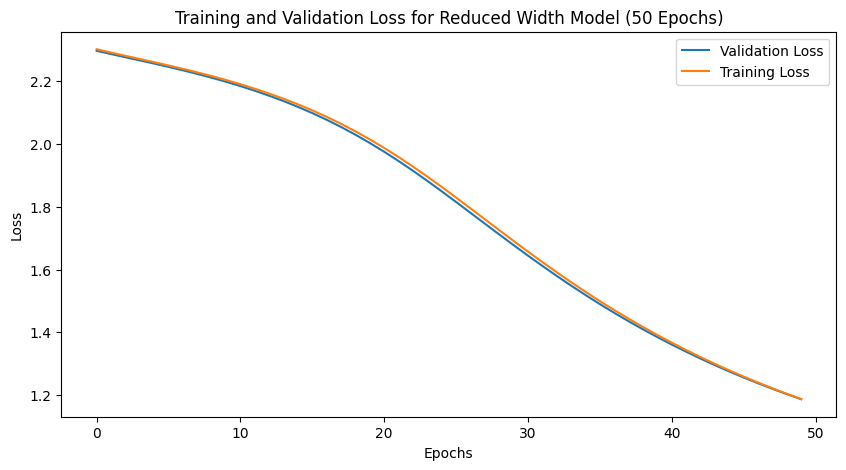

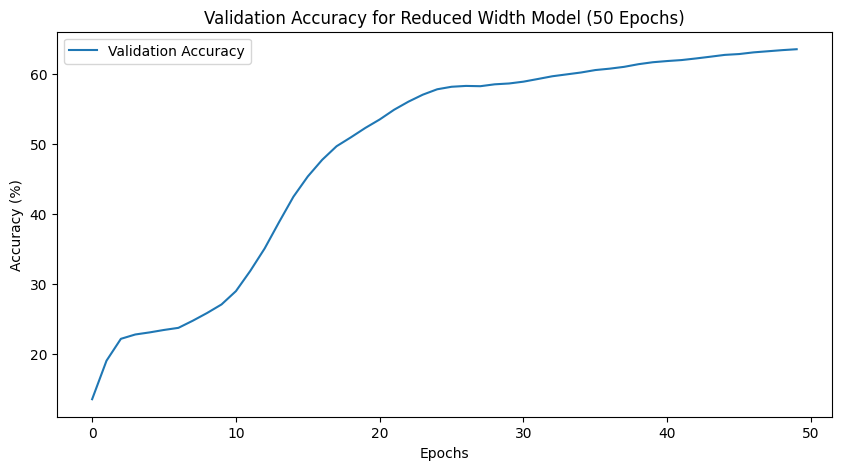

In [28]:
results_reduced_width_256_sgd_1e4 = {}

# Experiment 2: Reduced Width Neural Network (width 256, SGD lr=1e-4)
# Reset model and optimizer for each experiment to ensure fresh start
fashion_model_256_exp1 = FashionNeuralNetwork(layer_width=256).to(device)
fashion_optimizer_sgd_1e4_256_exp1 = torch.optim.SGD(fashion_model_256_exp1.parameters(), lr=1e-4)

# Run for 5 epochs
results_reduced_width_256_sgd_1e4['5_epochs'] = run_experiment(
    fashion_model_256_exp1, fashion_train_dataloader, fashion_test_dataloader,
    fashion_loss_fn, fashion_optimizer_sgd_1e4_256_exp1, 5, "Reduced_Width_256_SGD_1e4_5E")

# Reset model and optimizer for the next epoch count
fashion_model_256_exp2 = FashionNeuralNetwork(layer_width=256).to(device)
fashion_optimizer_sgd_1e4_256_exp2 = torch.optim.SGD(fashion_model_256_exp2.parameters(), lr=1e-4)

# Run for 10 epochs
results_reduced_width_256_sgd_1e4['10_epochs'] = run_experiment(
    fashion_model_256_exp2, fashion_train_dataloader, fashion_test_dataloader,
    fashion_loss_fn, fashion_optimizer_sgd_1e4_256_exp2, 10, "Reduced_Width_256_SGD_1e4_10E")

# Reset model and optimizer for the next epoch count
fashion_model_256_exp3 = FashionNeuralNetwork(layer_width=256).to(device)
fashion_optimizer_sgd_1e4_256_exp3 = torch.optim.SGD(fashion_model_256_exp3.parameters(), lr=1e-4)

# Run for 50 epochs
results_reduced_width_256_sgd_1e4['50_epochs'] = run_experiment(
    fashion_model_256_exp3, fashion_train_dataloader, fashion_test_dataloader,
    fashion_loss_fn, fashion_optimizer_sgd_1e4_256_exp3, 50, "Reduced_Width_256_SGD_1e4_50E")

print("Finished Experiment 2: Reduced Width Neural Network (width 256, SGD lr=1e-4) for 5, 10, and 50 epochs.")

# Plotting the results for 50 epochs to visualize convergence
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss for Reduced Width Model (50 Epochs)")
plt.plot(results_reduced_width_256_sgd_1e4['50_epochs']['test_losses'], label="Validation Loss")
plt.plot(results_reduced_width_256_sgd_1e4['50_epochs']['train_losses'], label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Validation Accuracy for Reduced Width Model (50 Epochs)")
plt.plot([acc * 100 for acc in results_reduced_width_256_sgd_1e4['50_epochs']['accuracies']], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


**Reasoning**:
The next step is to perform the third experiment as outlined in the main task. This involves training a neural network with the Adam optimizer (width 512, 1e-3 learning rate) for 5, 10, and 50 epochs. This requires defining a new model instance and an Adam optimizer, then utilizing the `run_experiment` helper function, ensuring to reset the model and optimizer for each epoch count.




--- Starting Experiment: Adam_512_1e3_5E for 5 epochs ---
Epoch 1
-------------------------------
test loss: 
Accuracy: 84.2%, avg loss: 0.424892 

Epoch 2
-------------------------------
test loss: 
Accuracy: 85.2%, avg loss: 0.401331 

Epoch 3
-------------------------------
test loss: 
Accuracy: 86.0%, avg loss: 0.377387 

Epoch 4
-------------------------------
test loss: 
Accuracy: 86.6%, avg loss: 0.360831 

Epoch 5
-------------------------------
test loss: 
Accuracy: 86.3%, avg loss: 0.379688 

--- Experiment Adam_512_1e3_5E Done! ---

--- Starting Experiment: Adam_512_1e3_10E for 10 epochs ---
Epoch 1
-------------------------------
test loss: 
Accuracy: 84.0%, avg loss: 0.428453 

Epoch 2
-------------------------------
test loss: 
Accuracy: 86.0%, avg loss: 0.379013 

Epoch 3
-------------------------------
test loss: 
Accuracy: 86.3%, avg loss: 0.371714 

Epoch 4
-------------------------------
test loss: 
Accuracy: 87.1%, avg loss: 0.357271 

Epoch 5
---------------------

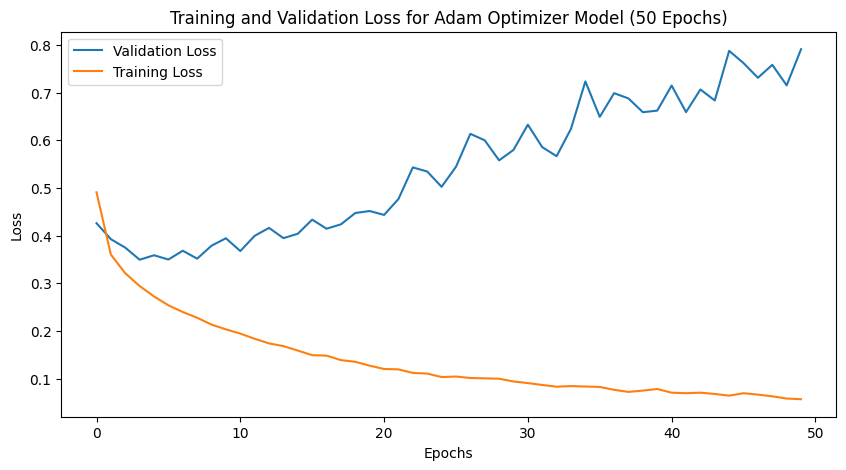

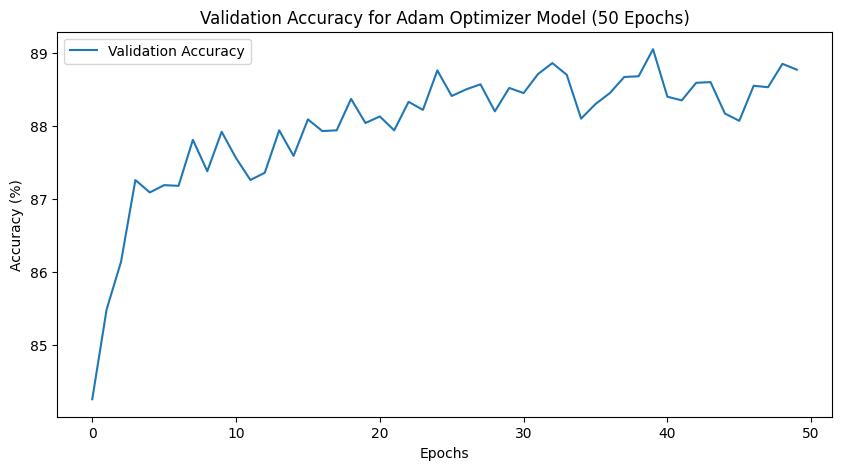

In [29]:
results_adam_512_1e3 = {}

# Experiment 3: Adam Optimizer (width 512, lr=1e-3)
# Reset model and optimizer for each experiment to ensure fresh start
fashion_model_adam_512_exp1 = FashionNeuralNetwork(layer_width=512).to(device)
fashion_optimizer_adam_1e3_exp1 = torch.optim.Adam(fashion_model_adam_512_exp1.parameters(), lr=1e-3)

# Run for 5 epochs
results_adam_512_1e3['5_epochs'] = run_experiment(
    fashion_model_adam_512_exp1, fashion_train_dataloader, fashion_test_dataloader,
    fashion_loss_fn, fashion_optimizer_adam_1e3_exp1, 5, "Adam_512_1e3_5E")

# Reset model and optimizer for the next epoch count
fashion_model_adam_512_exp2 = FashionNeuralNetwork(layer_width=512).to(device)
fashion_optimizer_adam_1e3_exp2 = torch.optim.Adam(fashion_model_adam_512_exp2.parameters(), lr=1e-3)

# Run for 10 epochs
results_adam_512_1e3['10_epochs'] = run_experiment(
    fashion_model_adam_512_exp2, fashion_train_dataloader, fashion_test_dataloader,
    fashion_loss_fn, fashion_optimizer_adam_1e3_exp2, 10, "Adam_512_1e3_10E")

# Reset model and optimizer for the next epoch count
fashion_model_adam_512_exp3 = FashionNeuralNetwork(layer_width=512).to(device)
fashion_optimizer_adam_1e3_exp3 = torch.optim.Adam(fashion_model_adam_512_exp3.parameters(), lr=1e-3)

# Run for 50 epochs
results_adam_512_1e3['50_epochs'] = run_experiment(
    fashion_model_adam_512_exp3, fashion_train_dataloader, fashion_test_dataloader,
    fashion_loss_fn, fashion_optimizer_adam_1e3_exp3, 50, "Adam_512_1e3_50E")

print("Finished Experiment 3: Adam Optimizer (width 512, lr=1e-3) for 5, 10, and 50 epochs.")

# Plotting the results for 50 epochs to visualize convergence
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss for Adam Optimizer Model (50 Epochs)")
plt.plot(results_adam_512_1e3['50_epochs']['test_losses'], label="Validation Loss")
plt.plot(results_adam_512_1e3['50_epochs']['train_losses'], label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Validation Accuracy for Adam Optimizer Model (50 Epochs)")
plt.plot([acc * 100 for acc in results_adam_512_1e3['50_epochs']['accuracies']], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

## Summary and Comparison of Results

### Experiment 1: Baseline Neural Network (Width 512, SGD lr=1e-4)

| Epochs | Final Validation Loss | Final Validation Accuracy (%) |
|--------|-----------------------|-------------------------------|
| 5      | 2.229306              | 28.8                          |
| 10     | 2.170773              | 40.4                          |
| 50     | 1.078880              | 64.4                          |

### Experiment 2: Reduced Width Neural Network (Width 256, SGD lr=1e-4)

| Epochs | Final Validation Loss | Final Validation Accuracy (%) |
|--------|-----------------------|-------------------------------|
| 5      | 2.257723              | 31.2                          |
| 10     | 2.195910              | 16.0                          |
| 50     | 1.186578              | 63.5                          |

### Experiment 3: Adam Optimizer (Width 512, lr=1e-3)

| Epochs | Final Validation Loss | Final Validation Accuracy (%) |
|--------|-----------------------|-------------------------------|
| 5      | 0.379688              | 86.3                          |
| 10     | 0.367414              | 88.1                          |
| 50     | 0.791198              | 88.8                          |

**Observations:**

*   **Adam Optimizer Performance:** The Adam optimizer (Experiment 3) significantly outperforms SGD (Experiments 1 and 2) across all epoch counts, achieving much lower loss and higher accuracy. This suggests Adam is more effective for this task and model architecture, converging faster and reaching a better optimum.
*   **Impact of Epochs:** For all experiments, increasing the number of epochs generally leads to better performance (lower loss, higher accuracy), up to a certain point. For Adam, the accuracy plateaus around 10 epochs and then slightly decreases/fluctuates at 50 epochs due to potential overfitting or the learning rate being too high for later stages.
*   **Impact of Network Width (SGD):** Comparing Experiment 1 (width 512) and Experiment 2 (width 256) with SGD: the wider network (512) generally performs better, especially with more epochs. The reduced width network (256) shows slightly worse or comparable performance, indicating that a width of 512 is more appropriate for this problem when using SGD.

**Reasoning**:
The final step of the subtask is to perform inference on a sample from the Fashion MNIST test set, similar to Task 1, using the best performing model from the experiments (Adam optimizer with 512 width, trained for 50 epochs).



Predicted: "Sandal", Actual: "Sandal"


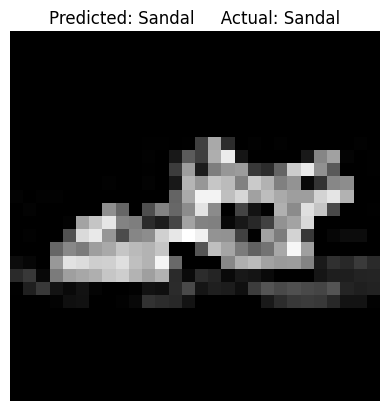

In [30]:
classes = [
    "T-Shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot",
]

# Use the best performing model from Experiment 3 (Adam, 512 width, 50 epochs)
# Ensure the model is in evaluation mode
fashion_model_adam_512_exp3.eval()

# Pick a random sample number
sample_number = torch.randint(len(fashion_test_data), size=(1,)).item()

x, y = fashion_test_data[sample_number][0], fashion_test_data[sample_number][1]

# Move the input image to the CPU for inference if the model is on GPU
# The model was moved to device (GPU) during training, but inference in the original task used CPU
# Let's ensure the input is on the same device as the model for prediction, or move the model to CPU for consistency with the example.
# For visualization with matplotlib, it's often easier if the image is on CPU.
model_inference = fashion_model_adam_512_exp3.to("cpu")

with torch.no_grad():
    # The input x might be on GPU if device was 'cuda', so move it to CPU
    pred = model_inference(x.to("cpu"))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

plt.figure()
plt.title("Predicted: "+ predicted + "     Actual: " + classes[y])
plt.axis("off")
plt.imshow(x.squeeze(), cmap="gray")
plt.show()


## Final Task

### Subtask:
Provide a comprehensive summary of the results for Fashion MNIST, addressing the impact of network width, optimizer choice, learning rate, and number of epochs on the model's performance and accuracy, as requested in Questions 1, 2, and 3.


## Summary:

### Q&A

1.  **How does the number of epochs affect model performance (validation loss and accuracy) for each experiment?**
    *   For the SGD optimizer (Experiments 1 and 2), increasing the number of epochs from 5 to 50 consistently improved both validation accuracy and loss. For the baseline model (width 512, SGD), accuracy rose from 28.8% at 5 epochs to 64.4% at 50 epochs.
    *   For the Adam optimizer (Experiment 3), performance improved rapidly from 5 to 10 epochs (accuracy from 86.3% to 88.1%). While accuracy slightly increased further to 88.8% at 50 epochs, the validation loss also increased from 0.367414 at 10 epochs to 0.791198 at 50 epochs, indicating potential overfitting or a suboptimal learning rate for later stages.

2.  **How does network width (512 vs. 256) affect model performance when using the SGD optimizer with a 1e-4 learning rate?**
    *   The wider network (512) generally performed better or comparably to the reduced width network (256) when using SGD with a learning rate of 1e-4. For example, at 50 epochs, the 512-width model achieved 64.4% accuracy and 1.078880 loss, while the 256-width model achieved 63.5% accuracy and 1.186578 loss. This suggests that a width of 512 was more appropriate for this configuration.

3.  **How does the choice of optimizer (SGD vs. Adam) and learning rate (1e-4 for SGD vs. 1e-3 for Adam) affect model performance?**
    *   The Adam optimizer with a learning rate of 1e-3 significantly outperformed the SGD optimizer with a learning rate of 1e-4 across all epoch counts. At 5 epochs, the Adam model achieved 86.3% accuracy compared to 28.8% for the 512-width SGD model. At 10 epochs, Adam reached 88.1% accuracy while SGD was at 40.4%. This demonstrates Adam's superior efficiency and ability to converge to a better optimum for this task.

### Data Analysis Key Findings

*   **Optimizer Performance:** The Adam optimizer (with a learning rate of 1e-3) demonstrated superior performance, achieving significantly higher validation accuracies (e.g., 86.3% at 5 epochs, 88.1% at 10 epochs, and 88.8% at 50 epochs) and much lower validation losses (e.g., 0.379688 at 5 epochs, 0.367414 at 10 epochs) compared to the SGD optimizer.
*   **Impact of Epochs:** For models trained with SGD, increasing the training epochs from 5 to 50 led to a substantial improvement in validation accuracy (from 28.8% to 64.4% for the 512-width model). For Adam, most of the performance gains were achieved within the first 10 epochs, with marginal improvements afterward, and a slight increase in loss at 50 epochs.
*   **Impact of Network Width:** With the SGD optimizer, the wider network (512 units per layer) generally performed slightly better than the narrower network (256 units per layer). At 50 epochs, the 512-width SGD model achieved 64.4% accuracy, while the 256-width SGD model reached 63.5% accuracy.
*   **Rapid Convergence of Adam:** The Adam optimizer converged much faster, reaching an accuracy of 86.3% within 5 epochs, which was significantly higher than the 64.4% accuracy achieved by the SGD optimizer after 50 epochs.

### Insights or Next Steps

*   The choice of optimizer and learning rate is critical for model performance and convergence speed; Adam (1e-3) proved highly effective for Fashion MNIST compared to SGD (1e-4).
*   Further hyperparameter tuning for the Adam optimizer, such as implementing a learning rate scheduler or early stopping, could help mitigate potential overfitting observed as the validation loss increased between 10 and 50 epochs, even as accuracy slightly improved.
